# Time Series Forecasting with Prophet - Daily Revenue

In [127]:
# Installing Packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import holidays

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")


In [ ]:
# Use seaborn whitegrid style for clean plots with subtle grids
plt.style.use('seaborn-whitegrid')

def mean_absolute_percentage_error(y_true, y_pred): 
    """
    Calculates the Mean Absolute Percentage Error (MAPE)
    between actual and predicted values.
    
    Parameters:
    - y_true: array-like of true values
    - y_pred: array-like of predicted values

    Returns:
    - MAPE as a float percentage
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 1. Data Exploration 

Date range: January 1, 2013 to August 15, 2017
Frequency: Daily observations

Key characteristics:
-Clear positive trend over time

-Strong weekly seasonality (higher values on weekends, lowest on Thursdays)

-Noticeable yearly seasonality, with peaks around the New Year

In [14]:
df = pd.read_csv('Downloads/data_load/train_sale.csv')
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [19]:
df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [84]:
# For simplicity, stripping out id, store_nbr, family, and onpromotion.
# Summing the sales by date, and date is converted to datetime, prophet ready.

# Step 1: Ensure date is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Step 2: Group and sum sales by date
df_prophet = df.groupby('date')['sales'].sum().reset_index()

# Step 3: Rename columns for Prophet
df_prophet = df_prophet.rename(columns={'date': 'ds', 'sales': 'y'})

In [85]:
df_prophet.head()

,ds,y
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229


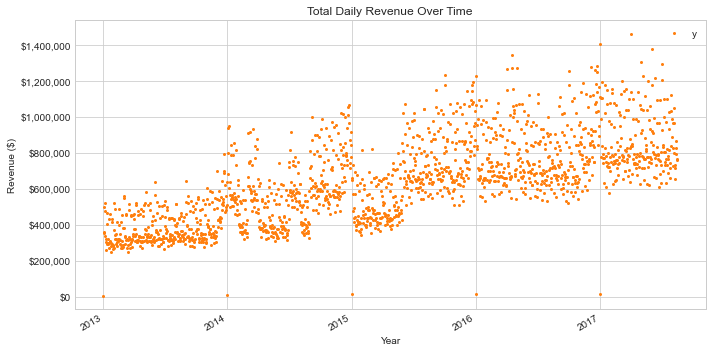

In [40]:
color_pal = sns.color_palette()

fig, ax = plt.subplots(figsize=(10, 5))

# Plot data
df_prophet.plot(
    x='ds',
    y='y',
    style='o',
    ms=2,
    color=color_pal[1],
    ax=ax,
    title='Total Daily Revenue Over Time'
)

# Format y-axis to show dollars
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Format x-axis to show years only
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Labels and layout
ax.set_xlabel('Year')
ax.set_ylabel('Revenue ($)')
plt.tight_layout()
plt.show()

In [41]:
from pandas.api.types import CategoricalDtype
import pandas as pd

# Define weekday order for categorical sorting
weekday_order = CategoricalDtype(
    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    ordered=True
)

def create_time_features(df, label=None):
    """
    Generate common time series features from a DataFrame with a datetime column 'ds'.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame with 'ds' datetime column.
    label (str): Name of the target variable column (e.g., 'y'). If provided, returns X and y.
    
    Returns:
    X (pd.DataFrame): Feature matrix.
    y (pd.Series): Target variable (if label provided).
    """
    df = df.copy()
    
    # Ensure datetime format
    df['date'] = pd.to_datetime(df['ds'])
    df.set_index('date', inplace=True)
    
    # Time-based features
    df['hour'] = df.index.hour                  # Always 0 for daily data, useful for hourly data
    df['dayofweek'] = df.index.dayofweek        # Monday=0, Sunday=6
    df['weekday'] = df.index.day_name()         # 'Monday', 'Tuesday', etc.
    df['weekday'] = df['weekday'].astype(weekday_order)
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    # Create seasonal grouping via date offset (for custom seasons)
    df['date_offset'] = (df.index.month * 100 + df.index.day - 320) % 1300
    df['season'] = pd.cut(
        df['date_offset'], 
        bins=[0, 300, 602, 900, 1300], 
        labels=['Spring', 'Summer', 'Fall', 'Winter']
    )
    
    # Select features
    feature_cols = [
        'hour', 'dayofweek', 'quarter', 'month', 'year',
        'dayofyear', 'dayofmonth', 'weekofyear', 'weekday', 'season'
    ]
    X = df[feature_cols]

    if label:
        y = df[label]
        return X, y
    
    return X

# Run the feature generator on df_prophet
X, y = create_time_features(df_prophet, label='y')

# Optional: Combine into a single DataFrame for inspection
features_and_target = pd.concat([X, y], axis=1)

# Preview
features_and_target.head()


,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,y
date,,,,,,,,,,,
2013-01-01,0,1,1,1,2013,1,1,1,Tuesday,Winter,2511.618999
2013-01-02,0,2,1,1,2013,2,2,1,Wednesday,Winter,496092.417944
2013-01-03,0,3,1,1,2013,3,3,1,Thursday,Winter,361461.231124
2013-01-04,0,4,1,1,2013,4,4,1,Friday,Winter,354459.677093
2013-01-05,0,5,1,1,2013,5,5,1,Saturday,Winter,477350.121229


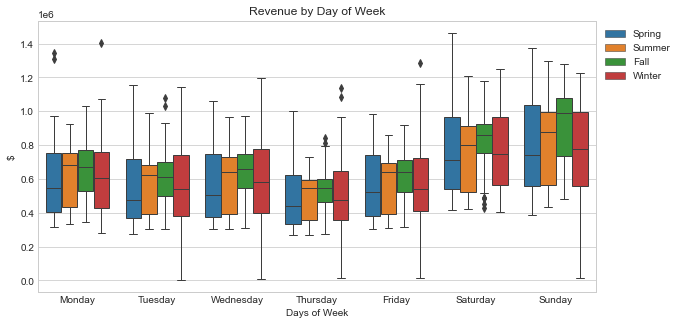

In [43]:
# Create a figure and axis object with specified size
fig, ax = plt.subplots(figsize=(10, 5))

sns.boxplot(
    data=features_and_target.dropna(),  # Drop missing values to avoid errors
    x='weekday',                       
    y='y',                             
    hue='season',                      # Group by 'season' with different colors
    ax=ax,                            # Plot on the specified axis
    linewidth=1                      
)

ax.set_title('Revenue by Day of Week')
ax.set_xlabel('Days of Week')
ax.set_ylabel('$')

# Place the legend outside the plot area
ax.legend(bbox_to_anchor=(1, 1))

plt.show()

In [44]:
df_prophet

,ds,y
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229
...,...,...
1679,2017-08-11,826373.722022
1680,2017-08-12,792630.535079
1681,2017-08-13,865639.677471
1682,2017-08-14,760922.406081


In [83]:
print(df_prophet.columns)

Index(['y'], dtype='object')


# 2. Training the simple Prophet Model 
Performance:
RMSE: 128,716.92

Given the average y value of ~1,000,000, this corresponds to a ~12.9% relative error

This is a subpar level of accuracy for time series forecasting with moderate variability

## *Improving the model by adding holidays in section 3


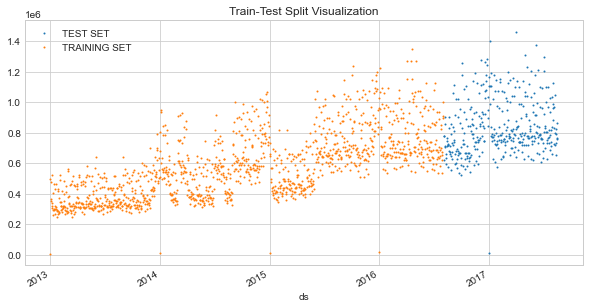

In [86]:
# Splitting the data to train and test.  We will use the first 3.5 years to train and last 1 for test.
df_prophet.set_index('ds', inplace=True)
split_date = '2016-08-01'

df_train = df_prophet.loc[df_prophet.index <= split_date].copy()
df_test = df_prophet.loc[df_prophet.index > split_date].copy()

# Plot the train and test target values
df_test.rename(columns={'y': 'TEST SET'}) \
    .join(df_train.rename(columns={'y': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10, 5), title='Train-Test Split Visualization', style='.', ms=2)

plt.show()

In [87]:
# Initialize the model
model = Prophet()

# Prepare training data 
df_train_prophet = df_train.reset_index()

# Fit the model
model.fit(df_train_prophet)

# Now you can predict
df_train_fcst = model.predict(df_train_prophet)

17:47:33 - cmdstanpy - INFO - Chain [1] start processing
17:47:33 - cmdstanpy - INFO - Chain [1] done processing


In [88]:
# Model summary
df_train_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,351833.067563,253618.395627,532810.711751,351833.067563,351833.067563,36096.821199,36096.821199,36096.821199,-62373.882438,-62373.882438,-62373.882438,98470.703637,98470.703637,98470.703637,0.0,0.0,0.0,387929.888762
1,2013-01-02,352101.212403,261341.860091,522379.872270,352101.212403,352101.212403,43149.036070,43149.036070,43149.036070,-43883.071729,-43883.071729,-43883.071729,87032.107799,87032.107799,87032.107799,0.0,0.0,0.0,395250.248473
2,2013-01-03,352369.357243,172393.545629,451226.210544,352369.357243,352369.357243,-44457.888733,-44457.888733,-44457.888733,-120123.077507,-120123.077507,-120123.077507,75665.188774,75665.188774,75665.188774,0.0,0.0,0.0,307911.468510
3,2013-01-04,352637.502083,221366.574656,488295.566245,352637.502083,352637.502083,3877.544109,3877.544109,3877.544109,-60652.448754,-60652.448754,-60652.448754,64529.992863,64529.992863,64529.992863,0.0,0.0,0.0,356515.046191
4,2013-01-05,352905.646922,396745.430398,674472.749933,352905.646922,352905.646922,180332.816071,180332.816071,180332.816071,126557.073364,126557.073364,126557.073364,53775.742707,53775.742707,53775.742707,0.0,0.0,0.0,533238.462993


In [89]:
# Prepare df_test for prediction
df_test_prophet = df_test.reset_index()

# Predict using the trained model
df_test_fcst = model.predict(df_test_prophet)

In [90]:
df_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-08-02,828449.543054,576829.253054,8.572876e+05,828449.543054,828449.543054,-106480.508059,-106480.508059,-106480.508059,-62373.882438,-62373.882438,-62373.882438,-44106.625621,-44106.625621,-44106.625621,0.0,0.0,0.0,721969.034995
1,2016-08-03,828719.095861,605767.576181,8.658948e+05,828719.095861,828719.095861,-91414.774680,-91414.774680,-91414.774680,-43883.071729,-43883.071729,-43883.071729,-47531.702951,-47531.702951,-47531.702951,0.0,0.0,0.0,737304.321181
2,2016-08-04,828988.648667,519100.115822,7.918870e+05,828988.648667,828988.648667,-170801.260911,-170801.260911,-170801.260911,-120123.077507,-120123.077507,-120123.077507,-50678.183404,-50678.183404,-50678.183404,0.0,0.0,0.0,658187.387757
3,2016-08-05,829258.201474,591038.752585,8.529527e+05,829258.201474,829258.201474,-114141.078802,-114141.078802,-114141.078802,-60652.448754,-60652.448754,-60652.448754,-53488.630048,-53488.630048,-53488.630048,0.0,0.0,0.0,715117.122672
4,2016-08-06,829527.754281,758428.551079,1.036569e+06,829527.754281,829527.754281,70647.241167,70647.241167,70647.241167,126557.073363,126557.073363,126557.073363,-55909.832196,-55909.832196,-55909.832196,0.0,0.0,0.0,900174.995448


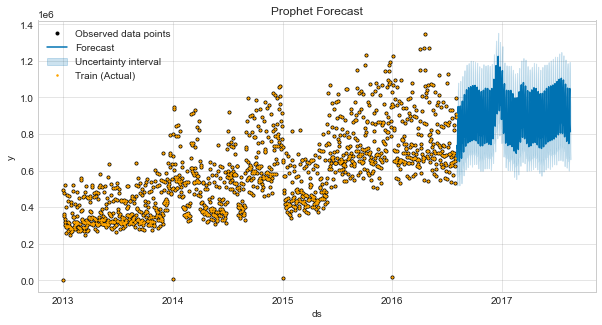

In [91]:
# Generate Prophet's forecast plot
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(df_test_fcst, ax=ax)

# Overlay training data in orange
df_train_plot = df_train.reset_index()
ax.plot(df_train_plot['ds'], df_train_plot['y'], '.', ms=3, color='orange', label='Train (Actual)')

# Add title and show plot
ax.set_title('Prophet Forecast')
ax.legend()
plt.show()

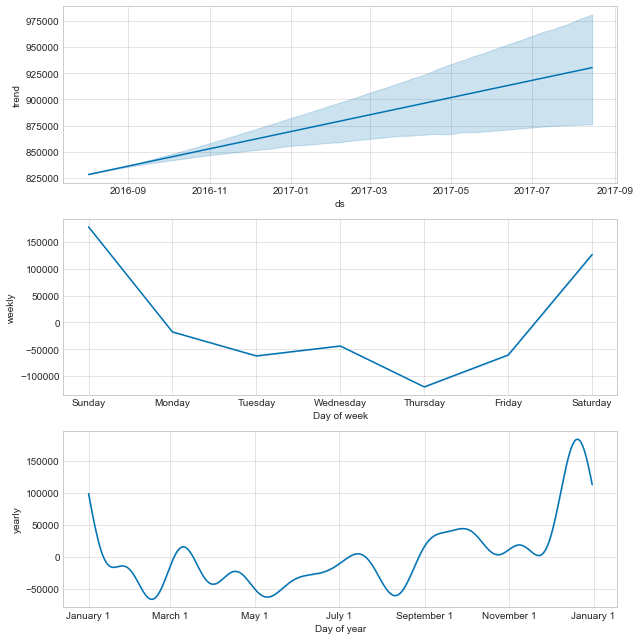

In [92]:
# visualizes the individual components that Prophet modeled and used to make its forecasts. 
# Interpret what the model "learned" from the data.

# We can see that there is:
# 1. overall positive growth
# 2. weekly seasonality, higher revnue on Sunday, Saturday.  Whereas Thursday is the lowest.
# 3. yearly sesaonality, higher revnue near the new year holiday season.

fig = model.plot_components(df_test_fcst)
plt.show()

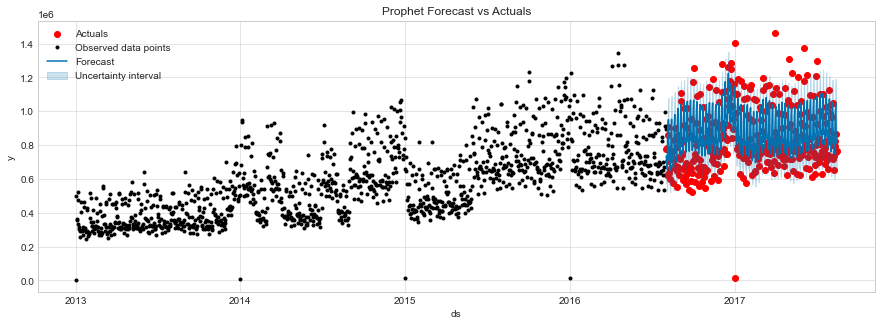

In [93]:
# Plot the forecast with the actuals
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(df_test.index, df_test['y'], color='r', label='Actuals')

# Overlay Prophet's forecast
fig = model.plot(df_test_fcst, ax=ax)
ax.set_title('Prophet Forecast vs Actuals')
ax.legend()

plt.show()

In [94]:
# evaluate the model
# An RMSE of 128,716.92,typical y values are around 1 million means about 12~13% error.
# 10-15% error can be acceptable especially with noisy data.
# but I will go further and add holiday into the data.

Relative RMSE = (128,716.92 / 1,000,000) × 100 ≈ 12.9%
rmse = np.sqrt(mean_squared_error(y_true=df_test['y'],
                                  y_pred=df_test_fcst['yhat']))
print(f'RMSE: {rmse:,.2f}')

RMSE: 128,716.92


# 3. Adding Holidays to Prophet Model 
Adding holiday indicators can improve model accuracy, especially when holidays impact the target variable. Prophet allows you to include these effects by providing a holidays DataFrame to the model before training, enabling it to account for recurring holiday patterns.

Result:
Initially, the model used US federal holidays which actually made the model performe worse.
Replaced with Ecuador-specific holidays, the model's RMSE improved to 110,920.79.

In [134]:
# Ensure datetime index
df_prophet.index = pd.to_datetime(df_prophet.index)

# Ensure datetime index
df_prophet.index = pd.to_datetime(df_prophet.index)

# Create Ecuador holiday calendar for your years of interest
ec_holidays = holidays.Ecuador(years=[2013, 2014, 2015, 2016, 2017])

# Convert Ecuador holidays to DataFrame for Prophet
holiday_df = pd.DataFrame(list(ec_holidays.items()), columns=['ds', 'holiday'])
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])


In [130]:
holiday_df

,ds,holiday
0,2016-01-01,Año Nuevo
1,2016-02-08,Carnaval
2,2016-02-09,Carnaval
3,2016-03-25,Viernes Santo
4,2016-05-01,Día del Trabajo
5,2016-05-24,Batalla de Pichincha
6,2016-08-10,Primer Grito de Independencia
7,2016-10-09,Independencia de Guayaquil
8,2016-11-02,Día de los Difuntos
9,2016-11-03,Independencia de Cuenca


In [101]:
print(df_train_prophet.columns)
print(df_train_prophet.isnull().sum())

Index(['ds', 'y'], dtype='object')
ds    0
y     0
dtype: int64


In [131]:
df_train_prophet['ds'] = pd.to_datetime(df_train_prophet['ds'])

# Ensure the 'ds' column is datetime
df_train_prophet['ds'] = pd.to_datetime(df_train_prophet['ds'])
df_test_prophet['ds'] = pd.to_datetime(df_test_prophet['ds'])

# Fit the model with holidays
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(df_train_prophet)

# Predict on train and test sets using the same trained model
df_train_fcst_with_hols = model_with_holidays.predict(df_train_prophet)
df_test_fcst_with_hols = model_with_holidays.predict(df_test_prophet)

19:03:38 - cmdstanpy - INFO - Chain [1] start processing
19:03:38 - cmdstanpy - INFO - Chain [1] done processing


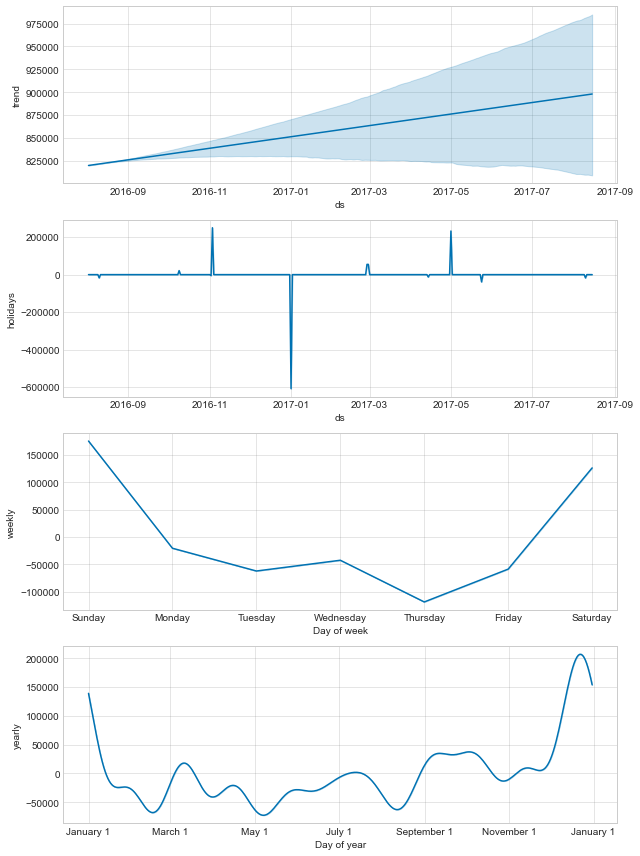

In [132]:
fig = model_with_holidays.plot_components(
    df_test_fcst_with_hols)
plt.show()

In [133]:
rmse = np.sqrt(mean_squared_error(
    y_true=df_test['y'],                # actual values in your test set
    y_pred=df_test_fcst_with_hols['yhat']  # predicted values from your Prophet model with holidays
))

print(f"RMSE: {rmse:,.2f}")

RMSE: 110,920.79


In [137]:
rmse = np.sqrt(mean_squared_error(
    y_true=df_test['y'],
    y_pred=df_test_fcst_with_hols['yhat']
))

mean_y = df_test['y'].mean()
rmse_pct = rmse / mean_y * 100

print(f"RMSE: {rmse:,.2f}")
print(f"RMSE as % of mean actual: {rmse_pct:.2f}%")

RMSE: 110,920.79
RMSE as % of mean actual: 13.25%


In [ ]:
# Initially, the model used US federal holidays which did not match the Ecuador sales data,
# leading to suboptimal forecast accuracy.
# After switching to Ecuador-specific holidays, the model's RMSE improved to 110,920.79,

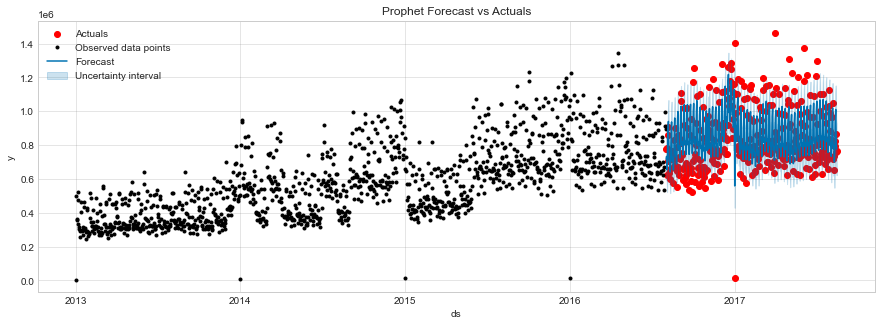

In [136]:
# Plot the forecast with the actuals
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(df_test.index, df_test['y'], color='r', label='Actuals')

# Overlay Prophet's forecast
fig = model.plot(df_test_fcst_with_hols, ax=ax)
ax.set_title('Prophet Forecast vs Actuals')
ax.legend()

plt.show()